In [1]:
from utils import *

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-npmc8p8c because the default path (/home/casoriano/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [28]:
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
<input type="submit" value="Click to toggle on/off the raw code.">
</form>

<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>''')

<img src="images/danbooru2.png" class="center" />

# TITLE
### Association Pattern Mining for Related Character Tags on Danbooru

## 1. Executive Summary

<div style='text-align: justify'>Association Analysis using the pyFIM algorithm has shown to be a relevant method of generating associated tags on the basis of an image’s character tag for the Danbooru image aggregator site. Characters have definite features associated with their design and this is not fully considered by Danbooru’s current methodology for suggesting Related Tags which utilizes the cosine distance of a particular tag’s use count. We filtered  the dataset to test our usecase on the 5 most popularly tagged characters and 5 undertagged characters which we determined based on the distribution of those characters' tags. Using Confidence from pyFIM’s arules method as a metric, we generated suggested tagsets for each of those characters' tags. We then compared pyFIM's generated tagsets with the current tags on each of the characters Related Tags page and compared the sets using the Jaccard similarity index. The generated tags produced a better description of each of the character's features in general tags validating the methodology of our usecase.</div>

## 2. Introduction

<div style='text-align: justify'>Image aggregation sites like Danbooru rely on text tagging so that users may be able to search for their desired content. Danbooru in particular utilizes a combination of user recommendations, Convolutional Neural Networks (CNNs) which are trained to identify images, and many other techniques to assign tags to each image. Our team aims to use Frequent Itemset Mining algorithms to as a supplementary tagging system that suggests related tags for images based-off an existing character tag. Suggestions would be generated from tags sets that are frequently grouped together that are found in other images of the particular character. With this proposed implementation, image tags would be generated instead of having to wait for users to submit tags which would take more time or relying solely on CNNs which are computationally expensive and have their own limitations.</div>

## 3. Problem Statement

<div style='text-align: justify'>How might we recommend related tags for sparsely tagged images of particular characters?</div>

## 4. Motivation / Business Value

<div style='text-align: justify'>With the vast amount of content available on Danbooru, the number usually exceeds the number of users, so a user tagged environment would result in an insufficient number of tags for the vast amount of content. CNNs on the other hand are computationally expensive to generate tags for a single image. Additionally, they are limited to the patterns they have learned to recognize and do not acknowledge the context of the features it recognizes. Images of characters have definite features associated with their design and many images are insufficiently tagged with the features of their appearance. This system can augment existing metadata by recommending related tags using an image’s character tag which would serve at some point as a ground truth label. Danbooru’s current related tag system uses cosine similarity between tags used for each post.
</div>

## 5. Data Description

<div style='text-align: justify'>The dataset is from Danbooru (https://www.kaggle.com/mylesoneill/tagged-anime-illustrations), an imageboard website and is accessible on Jojie via public data. The full dataset is 45.34GB. The images were scraped from the website including their metadata which includes tags associated with the image. The images are described as artwork depicting characters from Japanese anime. Most of the images were tagged as Safe-For-Work (SFW) or non-explicit, however, the website does not ban explicit or pornographic images and it is possible that mislabeled images are stll in the dataset.</div>

<table>
  <tr>
    <th>Feature</th>
    <th>Type</th> 
    <th>Description</th> 
  </tr>
  <tr>
    <td>id</td>
    <td>string</td>
    <td>The unqiue identification number assigned to the image in the dataset.</td> 
  </tr>
  <tr>
    <td>tags</td>
    <td>list of strings</td>
    <td>List of tags associated with an image sorted in lexicological order.</td> 
  </tr>
  <tr>
    <td>cat</td>
    <td>list of strings</td>
    <td>List of categories corresponding to tags in the same order.</td> 
  </tr>
</table>

The categories of tags are described as follows:

<table>
  <tr>
    <th>Label</th>
    <th>Category</th> 
    <th>Description</th>
  </tr>
  <tr>
    <td>0</td>
    <td>general</td>
    <td>Tags that are used for everything else.</td>
  </tr>
  <tr>
    <td>1</td>
    <td>artist</td>
    <td>Identify the creator of a post and does not necessarily correspond to the creator of the original copyrighted artwork.</td>
  </tr>
  <tr>
    <td>2</td>
    <td>???</td>
    <td>Unidentified by Danbooru documentation.</td>
  </tr>
  <tr>
    <td>3</td>
    <td>copyrights</td>
    <td>Identify the source material that the characters are from.</td>
  </tr>
  <tr>
    <td>4</td>
    <td>characters</td>
    <td>Identify the characters in the image.</td>
  </tr>
  <tr>
    <td>5</td>
    <td>meta</td>
    <td>Identify things beyond the content of the image itself such as if the image is translated.</td>
  </tr>
</table>

# Methodology

The methodology for this study is as follows:

<img src="images/methodology.png" class="center" />

<div style='text-align: center'><b>Figure 1.</b> The pipeline for the association pattern mining project for related tags.</div>

## 6. Extract metadata

<div style='text-align: justify'>The dataset was scraped from Danbooru. This includes both the image files and the metadata stored in JSON format. The dataset used was initially in a JSON dictionary format and for our methodology, we limited our scope to the contents of the <code>201700.json</code> file. We extracted these files using Pyspark database API to filter each image’s ID Number, Tags, and Categories per Tag and converted this into a Pandas DataFrame which we dumped into a pickle file for faster access. Becuase of the use of PySpark, it is possible to upscale this project in the future using the whole dataset with the use of PySpark. This significantly reduced the amount of data, thus making it more manageable.</di>

In [5]:
# extract_dataset()
data = load_dataset()
display(data.head())

,id,tag,cat
0,1000040,"[1boy, aqua_eyes, bad_id, bad_pixiv_id, dress,...","[0, 0, 5, 5, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,100007,"[1boy, 1girl, arm_holding, ass, bed, bedroom, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, ..."
2,1000070,"[1girl, brown_hair, flower, grey_eyes, japanes...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0]"
3,1000077,"[1boy, 2girls, comic, glowing, kaburagi_kaede,...","[0, 0, 0, 0, 4, 4, 0, 1, 5, 4, 0, 3, 5]"
4,1000080,"[1boy, 1girl, comic, fire, fire_emblem_(tiger_...","[0, 0, 0, 0, 4, 0, 4, 4, 1, 5, 4, 0, 0, 3, 5]"


## 7. Exploratory Data Analysis

### 1. Descriptive Analysis on Tags

<div style='text-align: justify'>Exploring the dataset, we see that there are 174158 unique images with an average 26 tags per image. In total, we observe 4562147 total tags in the dataset. Therefore, for the recommendations to be viable in terms of runtime and interpretability, the dataset should be filtered. </div>

In [7]:
data['id'].nunique()

174158

In [24]:
round(data['tag'].apply(len).mean(), 2)

26.2

In [10]:
len(data['tag'].explode())

4562147

### 2. Distribution of Tags

<div style='text-align: justify'>The top 10 most frequent tags are displayed below. The website is explicit in nature. Based on the top tags, it is inferred that a majority of the dataset is associated with female characters. However, this was expected due to the nature and culture surrounding this form of media.</div>

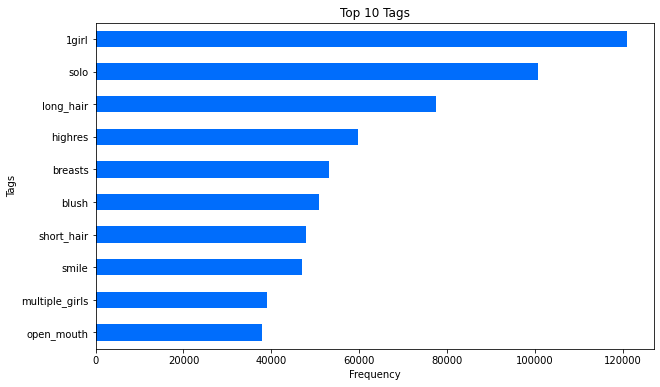

In [9]:
top10_tag_dist(data)

<div style='text-align: center'><b>Figure 2.</b> Content on Danbooru is concentrated on female characters.</div>

### 3. Distribution of Tags per Category

<div style='text-align: justify'>The distribution of tags are seen below. We see that <code>general</code> tags have the highest frequency in the dataset. They typically refer to the design traits of an image with <code>character</code> tags such as eye and hair color. Meanwhile, the remaining tags are more or less have similar frequencies.</div>

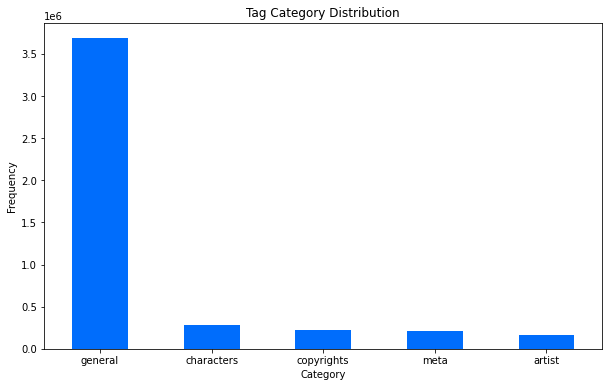

In [11]:
category_dist(data)

<div style='text-align: center'><b>Figure 3.</b> Most of the tags in the dataset are classified as <code>general</code>.</div>

### 4. Distribution of Images per Tag Category

<div style='text-align: justify'>Here we see that images almost have a uniform distribution of tag use by category. This means we expect that most images will have every single kind of tag but most especially the <code>general</code> and <code>copyrights</code> category of tags.</div>

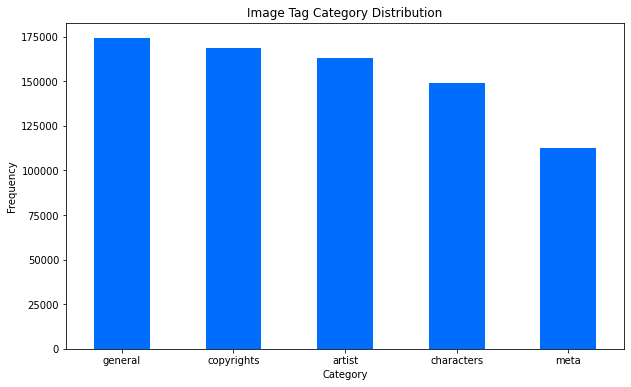

In [12]:
img_category_dist(data)

<div style='text-align: center'><b>Figure 4.</b> Images have an almost uniform distribution of tag category usage.</div>

## 8. Association Pattern Mining

<div style='text-align: justify'>Association Pattern Mining is an unsupervised method of finding frequent patterns, associations, and correlations among itemsets of transactions. Using the pyFIM module and the association rules method, we propose a new method of determining related tags specifically for characters that does not rely on cosine similarity. We first created a dictionary of all tags based on their category. In this way, we can filter the tags referring to character tags only. The reason for using character tags is that character designs will have some form of ground truth. An example would be <code>Hatsune_Miku</code> having some form of blue hair and blue eyes. Therefore, we would expect that a majority of the tags that are associated to Hatsune Miku would be <code>blue_hair</code> and <code>blue_eyes</code>. In this way, we can build a case that for character tags, most of their tags, and specifically <code>general</code> tags, would be design-related and are usually true to that character.</div>

In [13]:
cat_dict = category_dict(data)
display(cat_dict)

cat
0    [!, !!, !!?, !?, !?!, !_block, (-3-), (6), (9)...
1    [#104, #13, 'o'ne, ((((yuu)))), (stag), (ysy)s...
3    [#compass, &_love, '&'_-sora_no_mukou_de_sakim...
4    [(armor), 00_gundam, 00_qan[t], 00_raiser, 0_g...
5    [3rd_party_watermark, absurdres, alpha_transpa...
Name: tag, dtype: object

<div style='text-align: justify'>Then, the frequency distribution of tags for each character was tallied then arranged in descending order. In this way, we can determine which ranges of character tags frequencies would benefit the most for using Association Pattern Mining rather than building from scratch the tags with Convolutional Neural Netowrks (CNNs) or would expected to have mostly character design traits as tags. This also determines which tags generated would be most useful as related tags as these would be the ones that show up most often with other tags rather than based on the cosine similarity of the text of the tags. <br><br> 
Popular characters would be sufficiently tagged with many of them having tag counts of 2000 or more and characters with only 1 tag would not have related tags to form associations so these ones specifically would need the use of some image detection algorithm such as CNNs. Therefore, the sweet spot of those that can be used with this methodology is determined using the histogram as the cutoff.</div>

In [14]:
character_dist = char_dist(data)
display(character_dist)

,char,tag
0,hatsune_miku,3228
1,hakurei_reimu,3060
2,kirisame_marisa,2879
3,remilia_scarlet,2137
4,izayoi_sakuya,2059
...,...,...
34487,furret,1
34488,yhwach,1
34489,shiki_reika,1
34490,inari_(sennen_sensou_aigis),1


<div style='text-align: justify'>The distribution of the frequency of characters with their count of tags is displayed below as a histogram. For the proposed new methodology of determining related tags, we identified a sample of characters with tags ranging around <b>70 tags</b>, as those who have enough tags to perform some sort of association but not enough tags that they would still need some improvement for the related tags.</div>

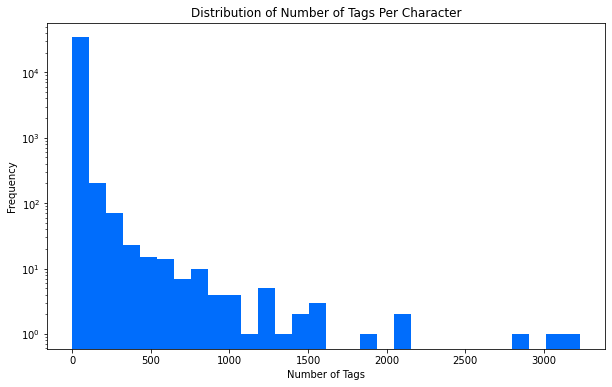

In [15]:
dist_tags_per_char(character_dist)

<div style='text-align: center'><b>Figure 5.</b> Distribution of tags of characters. More popular characters have more tags than those ones that are more obscure.</div>

<div style='text-align: justify'>Using character tags as the antecedent, we determine the tags most associated with the character tags based on their confidence and lift. We use five of the most frequent character tags, namely, <code>hatsune_miku</code>, <code>hakurei_reimu</code>, <code>kirisame_marisa</code>, <code>remilia_scarlet</code>, and <code>izayoi_sakuya</code>. For our use case, we then selected what we would consider under tagged characters, namely five low frequency character tags: <code>enemy_aircraft_(kantai_collection)</code>, <code>caster_(fate/zero)</code>, <code>mordred_(fate)</code>, <code>kamio_misuzu</code> and <code>yui_(angel_beats!)</code>. In this case, these would be at around the 73 tags. This tag frequency is also the basis of the relative support value of 0.20 that was used for all charcaters. The standard number of related tags in Danbooru is 25. A relative support too large will cut off the needed 25 related tags while a cutoff too low will result in a slower processing time.</div>

In [16]:
# scrape_tags()
df_test = related_vs_scraped(data, character_dist, load_scraped_tags())
display(df_test)

,tag,related_tags,scraped_tags,similarity
char,,,,
hatsune_miku,3228,"{thighhighs, 1girl, highres, blue_eyes, bad_pi...","{thighhighs, 1girl, kagamine_len, megurine_luk...",0.333333
hakurei_reimu,3060,"{red_eyes, ribbon, 2girls, hat, kirisame_maris...","{yellow_ascot, frilled_hair_tubes, hakurei_rei...",0.190476
kirisame_marisa,2879,"{ribbon, 2girls, hat, short_hair, hakurei_reim...","{hat, hat_bow, kirisame_marisa, hakurei_reimu,...",0.315789
remilia_scarlet,2137,"{blue_hair, red_eyes, ribbon, 2girls, hat, sho...","{koakuma, blue_hair, red_eyes, remilia_scarlet...",0.256410
izayoi_sakuya,2059,"{red_eyes, remilia_scarlet, ribbon, 2girls, ha...","{koakuma, remilia_scarlet, kirisame_marisa, 6+...",0.315789
enemy_aircraft_(kantai_collection),73,"{red_eyes, 2girls, shinkaisei-kan, hat, horns,...","{midway_princess, aircraft, turret, colored_sk...",0.086957
caster_(fate/zero),73,"{assassin_(fate/zero), 6+boys, berserker_(fate...","{assassin_(fate/zero), berserker_(fate/zero), ...",0.162791
mordred_(fate),73,"{breasts, looking_at_viewer, cleavage, short_h...","{hair_scrunchie, artoria_pendragon_(lancer)_(f...",0.136364
kamio_misuzu,73,"{blue_eyes, long_hair, ribbon, school_uniform,...","{hinokami_sakura, kanon, natsume_rin, key_(com...",0.028571


<div style='text-align: justify'>This dataframe above was built as follows:

1. For each character tag, the associated frequency of tags is also displayed to determine if it is a popular or less popoular character. This determines if the selection of ranges of tag frequency that would benefit the most from. using Association Pattern Mining.
2. Next, the top 25 related tags from the dataset was determined using the association rules' confidence and to an extent, lift. These will be used to compare to the actual tags on the website. With the character as the antecedent, we see which tags or groups of tags would be the consequent.
3. The 25 related tags for that character tag were determined by <em>scraping</em> the Danbooru website. This is important because it allows for the comparison of their current practice of using cosine similarity <em>between tags</em> rather than the patterns/associations between the tags.
4. Lastly, the Jaccard similarity of the related and scraped tags were determined. The higher the similarity value, the more the scraped tags were similar to the related tags.

The Jaccard similarity is calculated to see the helpfulness of the related tags on the website. Assuming that a character's related tags should mainly consist of their design traits, the related tags for character should also be mostly made up of general tags corresponding to this such as the example of Hatsune Miku having blue eyes and hair. In this way, these related tags would be more helpful. These general tags are what was determined from the dataset using Association Pattern Mining. So the closer the values of the scraped tags are to the related tags, the more helpful the related tags are.</div>

## 9. Results and Discussion

<div style='text-align: justify'>Below is a snapshot of the Danbooru website and how related tags are displayed. In this case, this is for the <code>Hatsune_Miku</code> character tag. The results for each character would be displayed in the same manner if the recommended associated tags were used by Danbooru.<br></div>

<img src="images/danbooru_related.png" class="center" />

In [30]:
display(df_test['related_tags'])

char
hatsune_miku                          {thighhighs, 1girl, highres, blue_eyes, bad_pi...
hakurei_reimu                         {red_eyes, ribbon, 2girls, hat, kirisame_maris...
kirisame_marisa                       {ribbon, 2girls, hat, short_hair, hakurei_reim...
remilia_scarlet                       {blue_hair, red_eyes, ribbon, 2girls, hat, sho...
izayoi_sakuya                         {red_eyes, remilia_scarlet, ribbon, 2girls, ha...
enemy_aircraft_(kantai_collection)    {red_eyes, 2girls, shinkaisei-kan, hat, horns,...
caster_(fate/zero)                    {assassin_(fate/zero), 6+boys, berserker_(fate...
mordred_(fate)                        {breasts, looking_at_viewer, cleavage, short_h...
kamio_misuzu                          {blue_eyes, long_hair, ribbon, school_uniform,...
yui_(angel_beats!)                    {blue_hair, tail, pink_hair, short_hair, angel...
Name: related_tags, dtype: object

<div style='text-align: justify'>From the series above, we see that the tags associated with characters are mostly comprised of <code>general</code> tags. These would be the most helpful for visitors on the website to select related tags to a certain character. With mainly their design features highlighted, this is also a more intuitive approach to determining related tags rather than based on text similarity. We can also recommend to Danbooru that the sorting of the tags can be based on confidence or lift rather than just pure frequency which is what is currently used.</div>

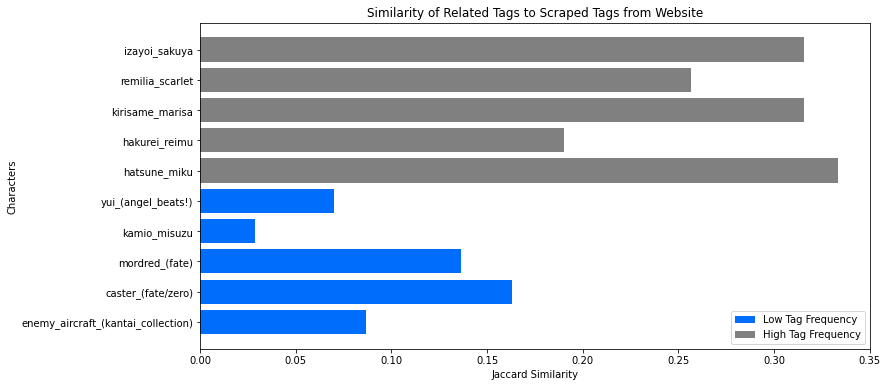

In [17]:
plot_similarity(df_test)

<div style='text-align: center'><b>Figure 6.</b> The differences of similarity of scraped tags and tags determined from Associated Pattern Mining between popular and less popular characters. In general, less popular characters have lower similarity therefore their related tags on Danbooru are less helpful than those recommended by the proposed methodology.</div>

<div style='text-align: justify'>By comparing the related tags scraped from Danbooru and the associated tags that were generated from the pyFIM algorithm, we compared the two sets using the Jaccard Similarity metric. This metric was used to gauge both the similarity and diversity of the tags associated with the character image. In the case of the popular characters, their images had a High Tag Frequency score and did not benefit much from the recommended associated tags. However, the less popular characters have a Lower Tag Frequency score and suggests that their currently listed “Related Tags” may not be as relevant as the associated tags produced by the algorithm and therefore are not as helpful. The reason for this may lie in the site’s current method of producing related tags. Their current methodology uses cosine similarity to see how many images each tag would have in common. Some limitations of this method would include its failure to consider <code>general</code> tags which would be descriptive for a character due to the sheer number of posts that would use a <code>general</code> tag. Another limitation is that characters and genres could sometimes be recommended by sheer popularity instead of relatability due to the metric.</div>

## 10. Conclusion

<div style='text-align: justify'>Frequent Itemset Mining algorithms proves to be a relevant tool in recommending additional metadata for images in the form of tags through Association Analysis. Although it suffers from cold start situations, it serves as a relevant method to supplement primary methods through association. This system can augment existing metadata by recommending associated tags using an image’s character tag which would serve as a ground truth label. Additionally, this system would be able to identify tags for an image using Frequent Itemset Mining algorithms which are less computationally expensive compared to solely using CNNs. These could even be used to complement CNNs which would tag characters, and the FIM implementations such as the methodology above would suggest associated tags after the character is identified.This algorithm can also be expanded to other datasets which contain images with an object ground truth such as images of cars could inherently have wheels. It would also be recommended that these could also be used in Danbooru's website interface as a supplement tag suggestion recommender where users can manually select if the images produce the specific tags. In this way, more ground truth labels can be acquired and used to train the tagging neural network models in their back end.</div>

## 11. Recommendations

<div style='text-align: justify'>In our methodology, confidence was used as a metric to determine the tagsets that would be most related to a particular character. This was done by filtering the dataset to include only a specific character then running the pyFIM <code>arules</code> algorithm. Originally, we wanted to explore using Lift as the key metric. However, lift could not be used because in order to use it properly, we would need to run the algorithm on the entire dataset which would be computationally expensive and there may not be significant differences to the results. For larger datasets, this method would need more computing resources relative to what is available to us currently. Additionally, huge datasets such as this carry a wealth of metadata so utilizing Association Analysis metrics that rely on probabilities generate potentially very small numbers which when divided wouldproduce big numbers that make it impractical for these metrics to benefit underused tags. It is also recommended in future study, that FIM be a possible solution to filling missing tags. Danbooru's API is comprehensive and scraping is difficult than expected. Therefore, testing for this requires more resources outside of this project's scope.<br><br>
It is also recommended that other frequent itemset libraries be explored. Since this dataset is scalable with the use of pySpark, it is recommended that a scalable library be used as well such as those built in to Spark (https://spark.apache.org/docs/latest/ml-frequent-pattern-mining.html).</div>

## References

[1] Gwern. “Danbooru2021: A Large-Scale Crowdsourced and Tagged Anime Illustration Dataset.” · Gwern.net, 21 Jan. 2022, https://www.gwern.net/Danbooru2021. 

[2] “Help:Api Wiki.” _Danbooru_, https://danbooru.donmai.us/wiki_pages/help:api. 

[3] King Natsu about 3 years ago, et al. “Meaning of the Related Tags.” _Danbooru_, https://danbooru.donmai.us/forum_topics/15848. 

[4] Moffitt, Chris. “Introduction to Market Basket Analysis in&nbsp;Python.” _Practical Business Python Atom_, 3 July 2017, https://pbpython.com/market-basket-analysis.html. 